In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
import cv2
import glob
from matplotlib import pyplot as plt

DATA_DIR = "/ml-data/handwrittenmathsymbols"
OPEN = True

## ETL

In [2]:
if not OPEN:
    # Loading math symbols
    symbols = [x.split('/')[-1] for x in glob.glob("{}/extracted_images/*".format(DATA_DIR))]

    # Loading images
    data = []
    for symbol in symbols:
        for img_file in glob.glob("{}/extracted_images/{}/*.jpg".format(DATA_DIR, symbol)):
            img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
            data.append([symbol, img])
    # Saving loaded data
    joblib.dump(data, "{}/{}.pickle".format(DATA_DIR, "data"))
        
    # One-hot encoding the symbols
    from sklearn import preprocessing

    ohe = preprocessing.LabelBinarizer()
    ohe.fit(symbols)

    # Saveing encoder
    joblib.dump(ohe, DATA_DIR + "/ohe.pickle")
else:
    ohe = joblib.load(DATA_DIR + "/ohe.pickle")
    
    data = joblib.load("{}/{}.pickle".format(DATA_DIR, "data"))

## Training

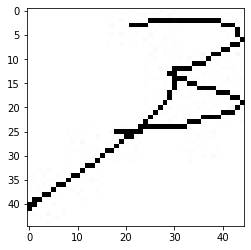

In [3]:
plt.imshow(data[0][1], cmap='gray')

## Single Model Training

In [4]:
# Splitting data insto training and test sets

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

print("Getting feature vector and target labes...")
X, y = np.stack(np.array(data)[:, 1]), np.array(data)[:, 0]

print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

Getting feature vector and target labes...
Splitting data into training and test sets...


In [5]:
X_train.shape, y_train.shape, len(ohe.classes_)

((263181, 45, 45), (263181,), 82)

In [12]:
import keras

keras.backend.clear_session()

input_shape = X_train[0].shape
output_shape = len(ohe.classes_)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=45, 
                              input_shape=(*input_shape, 1), 
                              data_format="channels_last",
                              kernel_size=(4, 4),
                              strides=(1, 1),
                              activation='relu', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                    strides=(2, 2)))
model.add(keras.layers.Conv2D(filters=20, 
                              data_format="channels_last",
                              kernel_size=(4, 4),
                              strides=(1, 1),
                              activation='relu', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                    strides=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(output_shape, 
                             activation='softmax',
                             kernel_initializer=keras.initializers.glorot_normal()))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 42, 45)        765       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 45)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 20)        14420     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1620)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 82)                132922    
Total params: 148,107
Trainable params: 148,107
Non-trainable params: 0
________________________________________________

In [9]:
def batch_generator(X, y, batch_size=32, shuffle=True):
    """
        Keras batch data generator for training
    """
    
    number_of_batches = int(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        # Get audio signal for each item ID
        X_batch = np.stack([
            cv2.normalize(X[idx], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) for idx in batch_index
        ])
        X_batch = np.expand_dims(X_batch, axis=3)
        y_batch = np.array([y[idx] for idx in batch_index])
        y_batch = ohe.transform(y_batch)
        counter += 1
        
        yield X_batch, y_batch
        
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [13]:
batch_size=32
epochs = 5

print("Computing class weights...")
weights = class_weight.compute_class_weight("balanced", ohe.classes_, y_train)

print("Training...")
history = model.fit_generator(generator=batch_generator(X_train, y_train, batch_size), 
                              epochs=epochs,
                              steps_per_epoch=X_train.shape[0]/batch_size,
                              validation_data=batch_generator(X_test, y_test, X_test.shape[0]).__next__(),
                              class_weight={x: weights[x] for x in range(len(weights))})

Computing class weights...
Training...
Epoch 1/5
8225/8224 [==============================] - 321s 39ms/step - loss: 1.3016 - accuracy: 0.6857 - val_loss: 0.7494 - val_accuracy: 0.7829
Epoch 2/5
8225/8224 [==============================] - 290s 35ms/step - loss: 0.4757 - accuracy: 0.8310 - val_loss: 0.4434 - val_accuracy: 0.8589
Epoch 3/5
8225/8224 [==============================] - 313s 38ms/step - loss: 0.3092 - accuracy: 0.8719 - val_loss: 0.3834 - val_accuracy: 0.8801
Epoch 4/5
8225/8224 [==============================] - 304s 37ms/step - loss: 0.2340 - accuracy: 0.8908 - val_loss: 0.3269 - val_accuracy: 0.8973
Epoch 5/5
8225/8224 [==============================] - 315s 38ms/step - loss: 0.1856 - accuracy: 0.9042 - val_loss: 0.3154 - val_accuracy: 0.9013


In [14]:
# serialize model to JSON
model_json = model.to_json()
with open("{}/model.json".format(DATA_DIR), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("{}/model.h5".format(DATA_DIR))

# Model performance

In [ ]:
from sklearn.metrics import roc_curve, auc

OPEN_MODEL = True

if OPEN_MODEL:
    from keras.models import model_from_json
    
    with open("{}/model.json".format(DATA_DIR), "r") as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    model.load_weights("{}/model.h5".format(DATA_DIR))

X_test_tr, y_test_tr = batch_generator(X_test, y_test, X_test.shape[0]).__next__()

In [10]:
y_test_pred = model.predict(X_test_tr)

In [21]:
pred_labels = ohe.inverse_transform(y_test_pred)
true_labels = ohe.inverse_transform(y_test_tr)

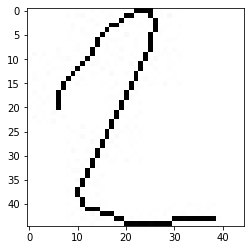

In [22]:
plt.imshow(X_test_tr[1, :, :, 0], cmap='gray')

In [42]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_fscore_support

matrix = confusion_matrix(true_labels, pred_labels)

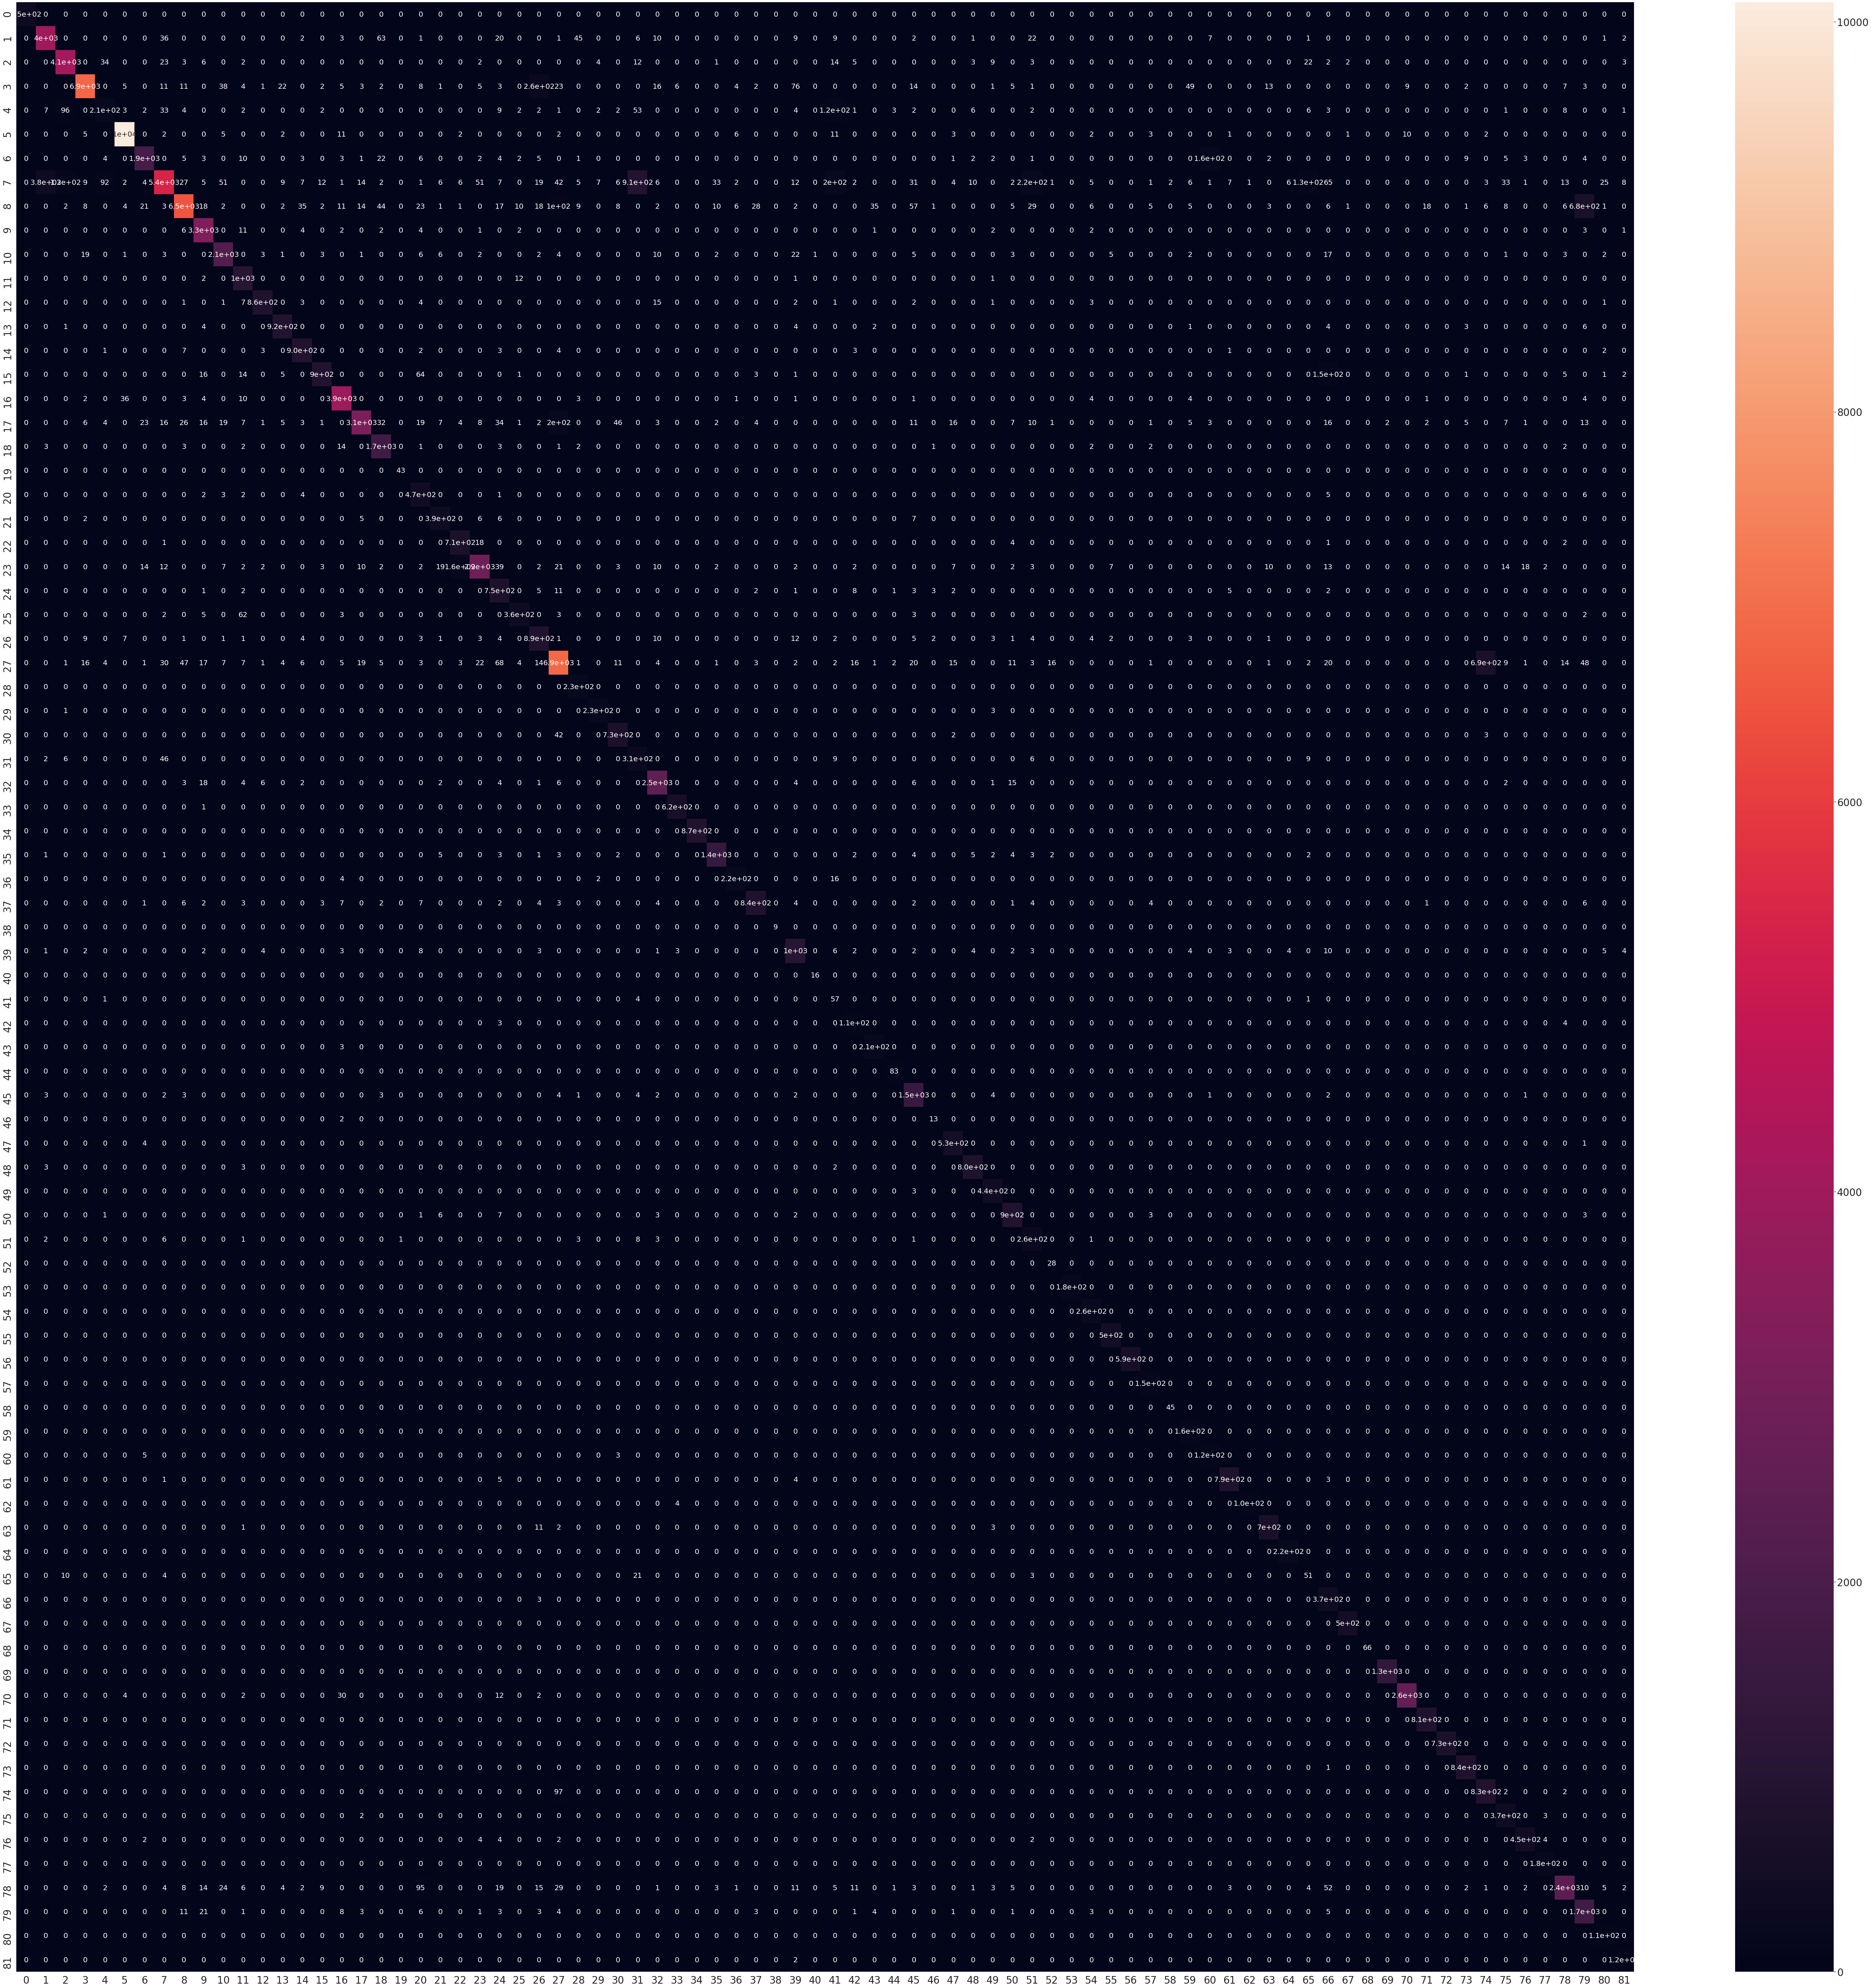

In [47]:
import seaborn as sn

plt.figure(figsize = (100,100))
sn.set(font_scale=2.5)
sn.heatmap(matrix, annot=True, annot_kws={"size": 20})

In [41]:
precision_recall_fscore_support(true_labels, pred_labels, labels=ohe.classes_, average=None)

(array([1.        , 0.90870056, 0.94346532, 0.98877213, 0.59259259,
        0.99389884, 0.96014493, 0.9581189 , 0.9737867 , 0.95397244,
        0.93109464, 0.86120401, 0.97627119, 0.94444444, 0.92346939,
        0.96051227, 0.97144276, 0.97747889, 0.90638075, 0.97727273,
        0.63885089, 0.87892377, 0.79910213, 0.95802552, 0.72920696,
        0.91282051, 0.70504732, 0.91937409, 0.76430976, 0.93877551,
        0.89962825, 0.23388306, 0.96102884, 0.97929936, 1.        ,
        0.96368527, 0.91735537, 0.94932432, 1.        , 0.85123967,
        0.94117647, 0.12472648, 0.66875   , 0.82868526, 0.92222222,
        0.89220855, 0.65      , 0.91206897, 0.96176822, 0.92600423,
        0.92938733, 0.4550173 , 0.58333333, 1.        , 0.88850174,
        0.97286822, 1.        , 0.88439306, 0.95744681, 0.66525424,
        0.41554054, 0.97530864, 0.99056604, 0.95901639, 0.95652174,
        0.21982759, 0.49933066, 0.99198397, 1.        , 0.99850299,
        0.99264706, 0.96642686, 1.        , 0.97